In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Sign Language Numbers

Our dataset, provided by Kaggle, includes 2062 images of sign language numbers. The following code will attempt to predict which number each hand symbol represents.

In [2]:
X = np.load("Sign-language-digits-dataset-2/X.npy")
Y = np.load("Sign-language-digits-dataset-2/Y.npy")

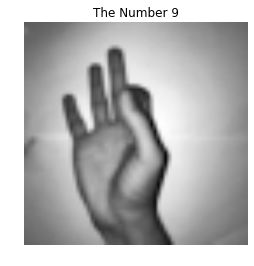

Data dimensions
(2062, 64, 64)
Target dimensions
(2062, 10)


In [3]:
plt.imshow(X[0],cmap="gray")
plt.title("The Number 9")
plt.axis('off')
plt.show()
d1,d2,d3 = X.shape
print("Data dimensions")
print(d1,d2,d3)
print("Target dimensions")
print(Y.shape)


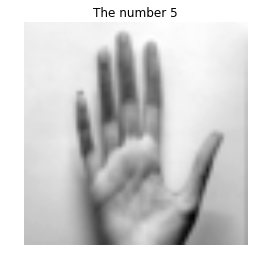

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [4]:
plt.imshow(X[-1],cmap='gray')
plt.title("The number 5")
plt.axis('off')
plt.show()
print(Y)

Unfortunately it looks like our signs are not grouped together in order and our target vector does not contain the number, only if they are a part of the same group of signs.

### Several Useful Functions

In [5]:
from sklearn.model_selection import train_test_split

def testModelAcc(model,X,y,numTests=20,tsize=.3):
    """ Function to test the accuracy of a sklearn
        model on suppied data.
        
        Parameters
        ----------
        model (sklearn model): i.e. Naive Bayes
        X (ndarray or pandas DF): data
        y (ndarray or pandas DF): target vector
        numTests (int > 0): number of train test splits
        tsize (0 < float < 1): portion of data to use as tests
        
        Returns
        _______
        name (string): model name
        accuracy (float): percent of correct predictions
        
    """
    accuracy = []
    #Repeated accuracy tests
    for i in range(numTests):
        #Split up the data
        splits = train_test_split(X,y,test_size =tsize)
        Xtrain,Xtest,ytrain,ytest = splits
        
        #Fit model
        fitted = model.fit(Xtrain,ytrain)       
        ypre = fitted.predict(Xtest)
        
        #Compute accuracy
        acc = sum(ypre==ytest)/float(len(ytest))
        accuracy.append(acc)
    
    #Return method name and average accuracy
    accuracy = np.mean(accuracy)
    name = str(model)[:str(model).find('(')]
    
    return name,accuracy

The above function was developed previously for testing machine learning methods.

### Shift by mean
First we shift each sign by the mean to help distinguishing features stand out.

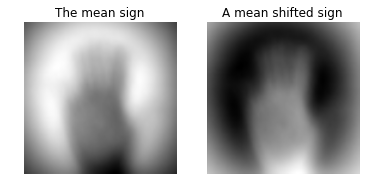

In [6]:
#Find the mean sign
mu = np.sum(X,axis=0)
#Shift all signs by the mean
Shifted = X-mu

plt.subplot(121)
plt.imshow(mu,cmap="gray")
plt.title("The mean sign")
plt.axis('off')
plt.subplot(122)
plt.imshow(Shifted[0]-mu,cmap='gray')
plt.title("A mean shifted sign")
plt.axis('off')
plt.show()

Before moving on to prediction, we will turn our target vector into a more useful form.

In [7]:
y = np.array([list(i).index(1) for i in Y])
print(y)

[0 0 0 ... 9 9 9]


### K Means
Next we will compute clusters with KMeans and determine the accuracy

In [8]:
from sklearn.cluster import KMeans

#Flatten each image
ShiftFlat = np.array([np.ravel(s) for s in Shifted])
info = testModelAcc(KMeans(),ShiftFlat,y)
print("Shifted {} accuracy: {}".format(info[0],info[1]))

Shifted KMeans accuracy: 0.0991114701131


Pretty low. This could be due to the small size of the dataset. Let's check the non shifted data to see if the mean shift made a difference

In [9]:
Flat = np.array([np.ravel(x) for x in X])
info = testModelAcc(KMeans(),Flat,y)
print("Non Shifted {} accuracy: {}".format(info[0],info[1]))

Non Shifted KMeans accuracy: 0.1049273021


### SVM
Support vector machine works well when the number of factors is greater than the number of observations, as is the case with this image data. We'll give it a try.

In [10]:
import sklearn.svm as svm
info = testModelAcc(svm.SVC(),ShiftFlat,y,numTests=1)
print("Shifted {} accuracy: {}".format(info[0],info[1]))

Shifted SVC accuracy: 0.463651050081


In [11]:
info = testModelAcc(svm.SVC(),Flat,y,numTests=1)
print("Non Shifted {} accuracy: {}".format(info[0],info[1]))

Non Shifted SVC accuracy: 0.29886914378


Next, we will optimize SVM using gridsearch to see how accurate the model is with other parameter values.

In [16]:
from sklearn.model_selection import GridSearchCV

#Make parameter dictionary
Cvals= np.logspace(-2, 10, 13)
gammaVals = np.logspace(-9, 3, 13)
params = dict(gamma=gammaVals, C=Cvals)

#Run the GridSearch
SignGrid = GridSearchCV(svm.SVC(kernel='rbf'), param_grid=params)
SignGrid.fit(Flat, y)
print("Best  SVM Accuracy: {}".format(SignGrid.best_score_))

NameError: name 'GadgetGrid' is not defined

In [21]:
SignGrid.best_params_

{'C': 10.0, 'gamma': 0.01}

Wow! Great accuacy from SVM. We will turn to neural networks to see if they preform better on the dataset.

### Neural Network

Neural Networks are know for their high accuracy in classifying images. We will build and optimize a sequential neural network model for predicting sign language digits.

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping


Using TensorFlow backend.


In [119]:
inputLen = d2*d3 #Length of flattened images

#Initialize model
NNet = Sequential()
#Add layers
NNet.add(Dense(units=8,activation='relu',input_dim=inputLen))
NNet.add(Dense(units=4,activation='relu'))
NNet.add(Dense(units=1,activation='sigmoid'))

NNet.summary()
# compile model
NNet.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

             

# define stopping criterion
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# fit model
x_train,x_test,y_train,y_test = train_test_split(Flat[:1800],Y[:1800])
hist = NNet.fit(x_train,
                y_train,
                batch_size=500,
                epochs=10,
                verbose=0,
                shuffle=True,
                validation_data=(x_test, y_test))
#                callbacks=[early_stopping])

# plot and return results
print(hist.history)
acc = hist.history['val_acc']
plt.plot(acc)
np.max(acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 8)                 32776     
_________________________________________________________________
dense_87 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 5         
Total params: 32,817
Trainable params: 32,817
Non-trainable params: 0
_________________________________________________________________


ValueError: Error when checking target: expected dense_88 to have shape (1,) but got array with shape (10,)

In [62]:
ones = np.ones((1000,1))
newX = np.vstack((np.outer(ones,Flat[0]),
                 np.outer(ones,Flat[1])))
                 
newY = np.vstack((np.outer(ones,Y[0]),
                 np.outer(ones,Y[2])))

In [13]:
inputLen = d2*d3 #Length of flattened images

#Initialize model
NNet = Sequential()
#Add layers
NNet.add(Dense(100,activation='relu',input_dim=inputLen))
NNet.add(Dense(20,activation='relu'))
NNet.add(Dense(10,activation='softmax'))
NNet.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

x_train,x_test,y_train,y_test = train_test_split(Flat[:1960],Y[:1960])
hist = NNet.fit(x_train,
                y_train,
                batch_size=40,
                epochs=200,
                verbose=0,
                shuffle=True,
                validation_data=(x_test, y_test),
                callbacks=[early_stopping])

# plot and return results
acc = hist.history['acc']
plt.plot(acc)

NameError: name 'early_stopping' is not defined